In [1]:
# ----------------------------------------------------------------------------
#
# TITLE - orbital_parameters.ipynb
# AUTHOR - James Lane
# PROJECT - OHStars
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''
Generate orbital parameters for the 6 outer halo stars. Sample 5D gaia kinematics with covariances and
determine orbital parameters and uncertainties using a MC approach.
'''

__author__ = "James Lane"

In [2]:
### Imports

## Basic
import numpy as np
import sys, os, pdb, warnings
from tqdm import tqdm_notebook as tqdm_nb

## Plotting
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import cm

## Astropy
from astropy import table
from astropy import units as apu
from astropy.utils.exceptions import AstropyWarning

## galpy
from galpy import orbit
from galpy import potential
from galpy.util import bovy_coords as gpcoords
from galpy.util import bovy_conversion as gpconv
from galpy.util import bovy_plot as gpplot

# Project-specific
sys.path.append('../../src')
import ohstars.analysis
import ohstars.potential

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/galpy/potential/DiskSCFPotential.py:190: RuntimeWarning: divide by zero encountered in double_scalars
  ts= lambda R, trd=rd, trm=rm: numpy.exp(-trm/R-R/trd)

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/galpy/potential/DiskSCFPotential.py:194: RuntimeWarning: divide by zero encountered in double_scalars
  ((trm/R**2.-1./trd)**2.-2.*trm/R**3.)*numpy.exp(-trm/R-R/trd)

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/galpy/potential/DiskSCFPotential.py:194: RuntimeWarning: invalid value encountered in double_scalars
  ((trm/R**2.-1./trd)**2.-2.*trm/R**3.)*numpy.exp(-trm/R-R/trd)

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/galpy/potential/DiskSCFPotential.py:477: RuntimeWarning: divide by zero encountered in double_scalars
  out-= a*(s(r)*h(z)+d2s(r)*H(z)+2./r*ds(r)*(H(z)+z*dH

In [3]:
### Matplotlib for notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Meta
## Future Work
- Add in extra systematic error, 0.035 mas? Following Gaia, Helmi + 2018

## Information
- Gaia co-variance information: https://www.aanda.org/articles/aa/pdf/2012/07/aa18807-12.pdf

# Preparation
## Keywords

In [4]:
# Number of samples
n_samples = 100

# Perform the analysis on all stars? False for skip
include_stars = [True, True, True, True, True, True]

# Integration keywords
t_orbit = [2,10,1,40,3,2] # Gyr

## Read Data

In [5]:
# Filename
filename = '../../data/gaia/allstars.vot'

# Read the file
with warnings.catch_warnings():
    warnings.simplefilter('ignore', AstropyWarning)
    tab = table.Table.read(filename)
###w

star_names = tab['col1'].data.astype(str)

In [10]:
star_names

masked_BaseColumn(data=['G233-026', 'G037-037', 'G158-100', 'G184-007',
                        'G189-050', 'G262-021'],
                  mask=[False, False, False, False, False, False],
            fill_value='N/A',
                 dtype='<U8')

## Prepare RV Data

In [11]:
# RV is uncorrelated with gaia so sample individually.

# From Carney (probably?)
# vrad = np.array([-314.41, -136.80, -361.75, -372.09, -321.48, -214.37 ])
# vrad_err = np.array([0.26,0.14,0.67,0.32,0.28,0.26])

# From Table 4, M19
vrad = np.array([-318.63, # 233-026
                 -142.99, # 037-037 
                 -360.60, # 158-100
                 -370.64, # 184-007
                 -320.90, # 189-050
                 -214.00, # 262-021
                ])
vrad_err = np.array([0.64, # 233-026
                     0.40, # 037-037 
                     1.10, # 158-100
                     0.50, # 184-007
                     0.60, # 189-050
                     0.50, # 262-021
                    ])

## Write function to evaluate orbit parameters

In [7]:
def evaluate_orbit_parameters(pot, potname, n_samples, star_names, tab, vrad, vrad_err, include_stars):
    '''evaluate_orbit_parameters:
    
    Args:
    
    Returns:
        
    '''
    
    
    n_stars = len(star_names)
    n_stars_use = include_stars.count(True)
    all_stats = np.empty(n_stars_use,dtype='object')
    star_counter = 0
    
    if potname == 'McMillan2017':
        m17_ro = 8.21
        m17_vo = 233.1
    ##fi
    
    # Loop over all stars
    for i in range(n_stars):
        
        # Evaluate?
        if include_stars[i] == False:
            continue
        ##fi
        
        # Make the figure
        fig = plt.figure( figsize=(15,8) )
        axs = fig.subplots( nrows=2, ncols=3 )

        # Sample the data
        samples, _ = ohstars.analysis.sample_kinematics( tab[i], n_samples=n_samples )
        rv_samples = np.random.normal( vrad[i], vrad_err[i], size=n_samples )

        # Timing:
        n_snaps = 1000 * t_orbit[i] # 1/Myr
        times = np.linspace(0,t_orbit[i],n_snaps) * apu.Gyr

        # Arrays to hold output parameters
        peri = np.zeros(n_samples)
        apo = np.zeros(n_samples)
        Lz = np.zeros(n_samples)
        Tr = np.zeros(n_samples)
        ecc = np.zeros(n_samples)

        # Loop over the trials
        for j in tqdm_nb( range(n_samples) ):

            # Unpack the sample:
            ra, dec, par, pmra, pmdec = samples[j]
            rv = rv_samples[i]
            dist = 1/par # In kpc

            # Now declare the orbit
            if potname == 'MWPotential2014':
                o = orbit.Orbit( vxvv=[ra, dec, dist, pmra, pmdec, rv], radec=True )
            if potname == 'McMillan2017':
                o = orbit.Orbit( vxvv=[ra, dec, dist, pmra, pmdec, rv], radec=True, 
                                 ro=m17_ro, vo=m17_vo)
            ##fi

            # Integrate
            o.integrate(times, pot)

            # Output
            n_params = 5
            peri[j] = o.rperi().value # Kpc
            apo[j] = o.rap().value # Kpc
            Lz[j] = np.average( o.vT(times) * o.R(times) ).value # Kpc Km/s
            if potname == 'MWPotential2014':
                Tr[j] = o.Tr(pot=pot, type='staeckel').value # Gyr
                ecc[j] = o.e(pot=pot, type='staeckel') # unitless
            if potname == 'McMillan2017':
                Tr[j] = o.Tr(pot=pot, type='staeckel', delta=0.45).value # Gyr
                ecc[j] = o.e(pot=pot, type='staeckel', delta=0.45) # unitless
            ##fi

        # Determine values to plot and calculate
        plot_params = np.array([peri,apo,Lz,Tr,ecc])
        plot_labels = np.array([r'$r_{peri}$ [kpc]',
                                r'$r_{apo}$ [kpc]',
                                r'$L_{z}$ [kpc km/s]',
                                r'$T_{rad} [Gyr]$',
                                r'$e$']) 
        plot_labels_plain = np.array(['rp [kpc]','rapo [kpc]','Lz [kpc km/s]','Tr [Gyr]','eccen.'])

        # Arrays for statistics
        stats_arr = np.zeros((5,3))
        
        for k in range(n_params):
            
            # Get parameter and compute statistics
            param = plot_params[k]
            param_median = np.median(param)
            param_c68p_l = np.sort(param)[int(0.16*n_samples)]
            param_c68p_u = np.sort(param)[int(0.84*n_samples)]
            
            stats_arr[k,0] = param_median
            stats_arr[k,1] = param_median-param_c68p_l
            stats_arr[k,2] = param_c68p_u-param_median
            
        ###k
        
        # Loop over all axes
        for k in range(3):
            for l in range(2):
                
                if 2*k+l > n_params-1: 
                    axs[l,k].set_axis_off()
                    continue
                
                # Get parameter and compute statistics
                param = plot_params[2*k+l]    
                param_median = np.median(param)
                param_c68p_l = np.sort(param)[int(0.16*n_samples)]
                param_c68p_u = np.sort(param)[int(0.84*n_samples)]

                # Make histograms
                bin_n, bins = np.histogram( param )
                axs[l,k].step(bins[:-1], bin_n, where='post', color='Black')
                axs[l,k].plot([bins[-2],bins[-1]], [bin_n[-1],bin_n[-1]], color='Black')
                axs[l,k].axvline( param_median, linestyle='solid', color='Red', linewidth=0.5 )
                axs[l,k].axvline( param_c68p_l, linestyle='dashed', color='Red', linewidth=0.5 )
                axs[l,k].axvline( param_c68p_u, linestyle='dashed', color='Red', linewidth=0.5 )
                axs[l,k].set_xlim( np.min(param), np.max(param) )
                axs[l,k].set_xlabel(plot_labels[2*k+l], fontsize=16)
                axs[l,k].set_ylabel('N', fontsize=16)
        
        fig.set_facecolor('White')
        fig.savefig('plots/'+potname+'/'+star_names[i]+'_orbital_param_pdf.pdf')
        fig.suptitle(star_names[i], fontsize=20)

        plt.show()
        plt.close('all')
        
        # Print information to screen and file
        outfile = open('./orbital_parameters/'+potname+'/'+star_names[i]+'_orbital_param.txt','w')
        outfile.write('# '+plot_labels_plain[0]+', '+plot_labels_plain[1]+', '+plot_labels_plain[2]+', '+plot_labels_plain[3]+': median, -err, +err\n')
        
        print(star_names[i])
        print('========')
        for k in range(n_params):
            print(plot_labels_plain[k])
            print('Median: '+str( round(stats_arr[k,0],4)) )
            print('Central 68th percentile: ['+str(round(stats_arr[k,0]-stats_arr[k,1],4))+','+str(round(stats_arr[k,0]-stats_arr[k,1],4))+']')
            print('Errors: ['+str(round(stats_arr[k,1],4))+','+str(round(stats_arr[k,2],4))+']\n')
        ###k
        
        outfile.close()
        
        all_stats[star_counter] = stats_arr
        star_counter += 1
    
    # No output
    return all_stats

#def

def make_latex_table(stats, star_names, filename):
    
    fileout = open(filename, 'w')
    
    n_stars = len(stats)
    n_params = stats[0].shape[0]
    
    # Assuming 5 parameters
    fileout.write('Name & $r_{peri}$ [kpc] & $r_{apo}$ [kpc] & $L_{z}$ [kpc km/s] & $T_{rad} [Gyr]$ & $e$ \\ \n')
    fileout.write('\hline \n')
    
    def stround(num,nround):
        return str(round(num,nround))
    
    for i in range( n_stars ):
        
        fileout.write( star_names[i] + ' & ' )
        
        for j in range( n_params ):
            
            fileout.write('$' + stround(stats[i][j,0],3) +\
                          '^{+' + stround(stats[i][j,1],3) + '}' +\
                          '_{-' + stround(stats[i][j,2],3) + '}$' +\
                          ' & ')
        ###j
        fileout.write('\\ \n')
    ###i
    fileout.write('\hline \n')
    fileout.close()
#def

# Determine Orbital Parameters
Use different potentials. Start with MWPotential2014 then use McMillan 2017

## MWPotential2014
Loop over each star and determine orbital parameters

A Jupyter Widget

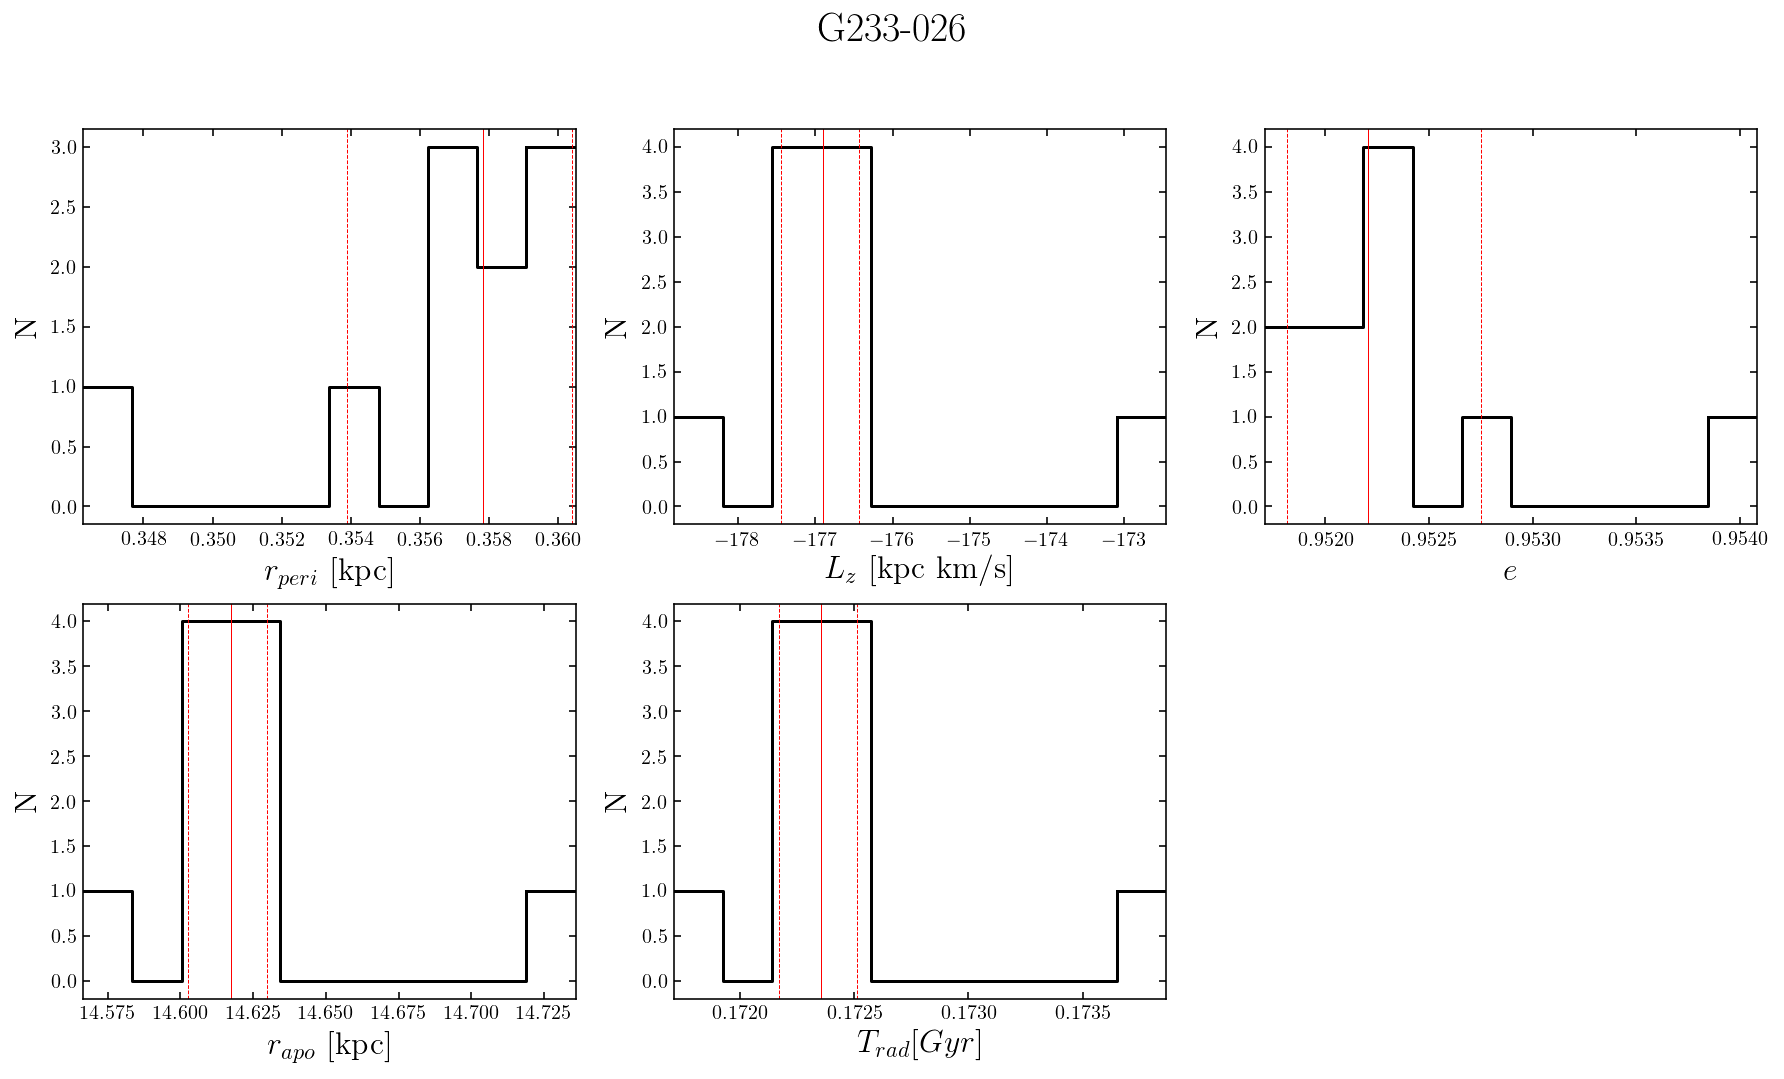

G233-026
rp [kpc]
Median: 0.3578
Central 68th percentile: [0.3539,0.3539]
Errors: [0.0039,0.0026]

rapo [kpc]
Median: 14.6173
Central 68th percentile: [14.6027,14.6027]
Errors: [0.0147,0.0124]

Lz [kpc km/s]
Median: -176.9044
Central 68th percentile: [-177.4456,-177.4456]
Errors: [0.5412,0.4731]

Tr [Gyr]
Median: 0.1724
Central 68th percentile: [0.1722,0.1722]
Errors: [0.0002,0.0002]

eccen.
Median: 0.9522
Central 68th percentile: [0.9518,0.9518]
Errors: [0.0004,0.0005]



A Jupyter Widget

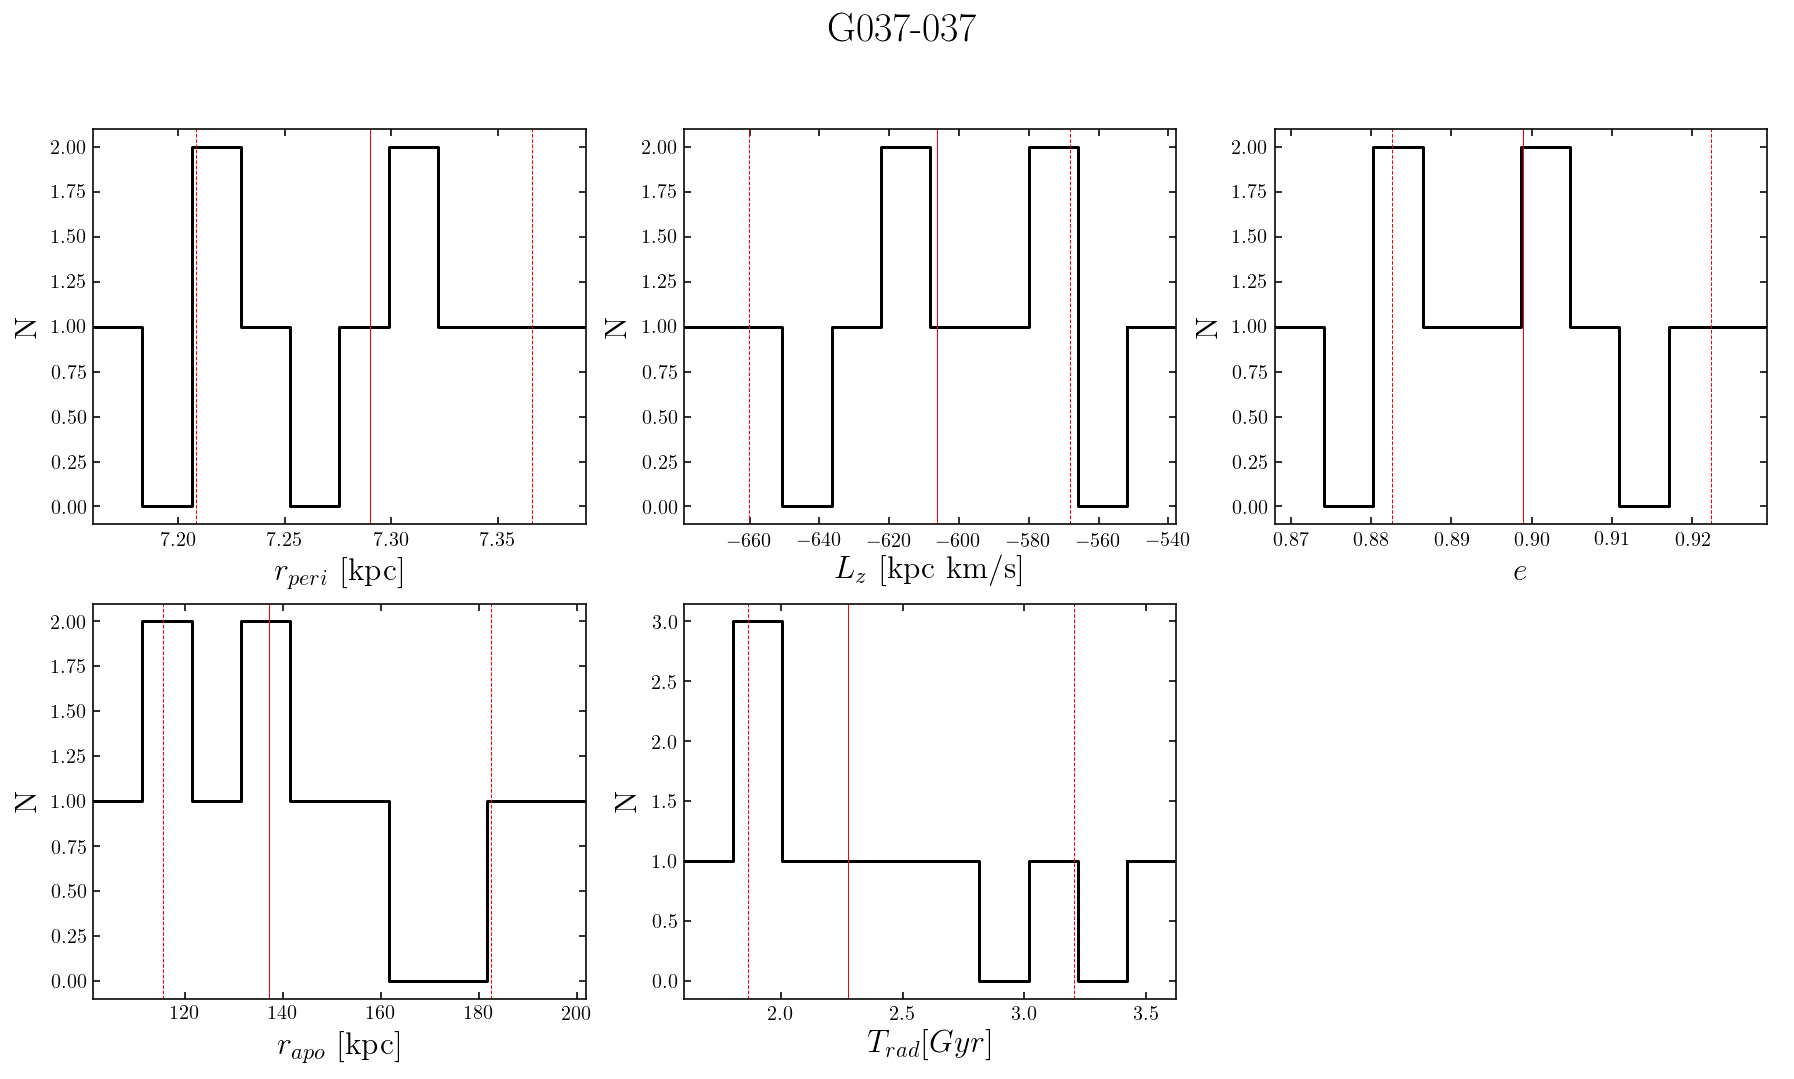

G037-037
rp [kpc]
Median: 7.2899
Central 68th percentile: [7.2082,7.2082]
Errors: [0.0816,0.0765]

rapo [kpc]
Median: 137.1119
Central 68th percentile: [115.5716,115.5716]
Errors: [21.5403,45.3129]

Lz [kpc km/s]
Median: -606.417
Central 68th percentile: [-660.204,-660.204]
Errors: [53.787,38.3463]

Tr [Gyr]
Median: 2.2763
Central 68th percentile: [1.8628,1.8628]
Errors: [0.4136,0.9297]

eccen.
Median: 0.8989
Central 68th percentile: [0.8826,0.8826]
Errors: [0.0164,0.0234]



A Jupyter Widget

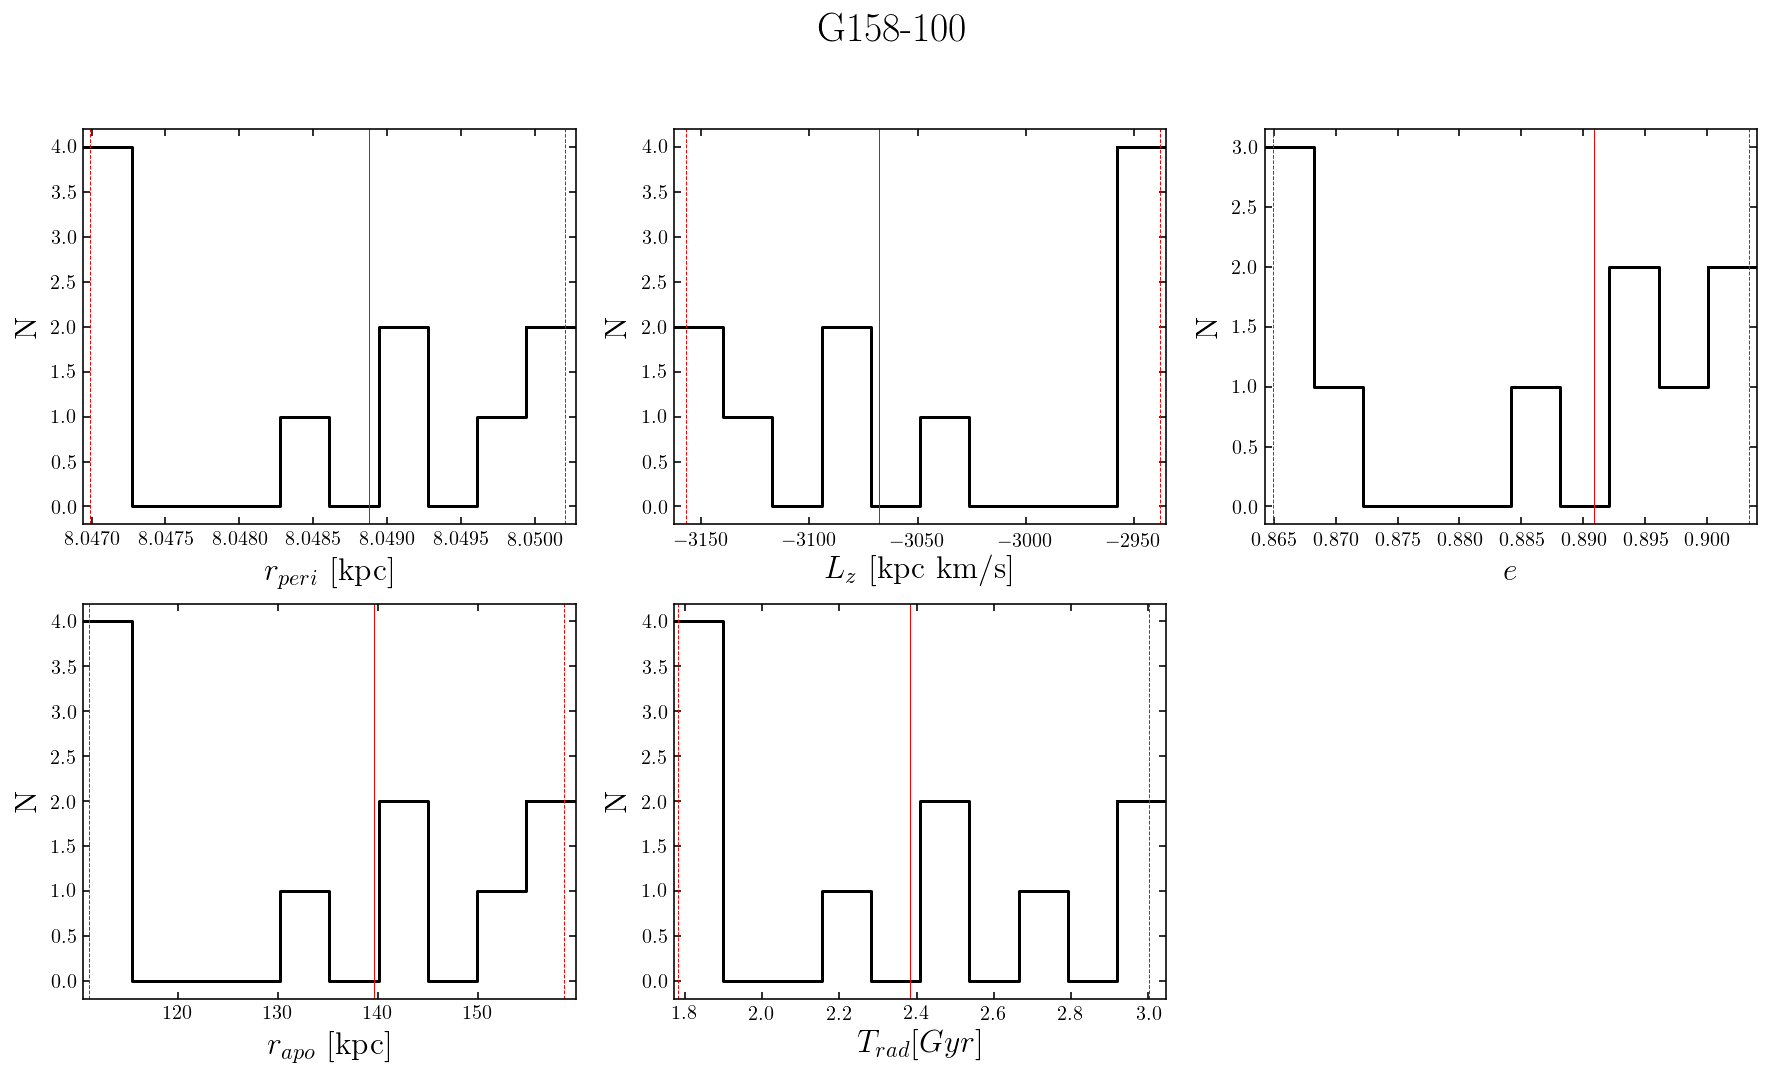

G158-100
rp [kpc]
Median: 8.0489
Central 68th percentile: [8.047,8.047]
Errors: [0.0019,0.0013]

rapo [kpc]
Median: 139.5734
Central 68th percentile: [111.1206,111.1206]
Errors: [28.4528,19.05]

Lz [kpc km/s]
Median: -3067.6397
Central 68th percentile: [-3157.0161,-3157.0161]
Errors: [89.3764,129.7568]

Tr [Gyr]
Median: 2.384
Central 68th percentile: [1.7829,1.7829]
Errors: [0.601,0.6171]

eccen.
Median: 0.8908
Central 68th percentile: [0.8649,0.8649]
Errors: [0.0259,0.0126]



A Jupyter Widget

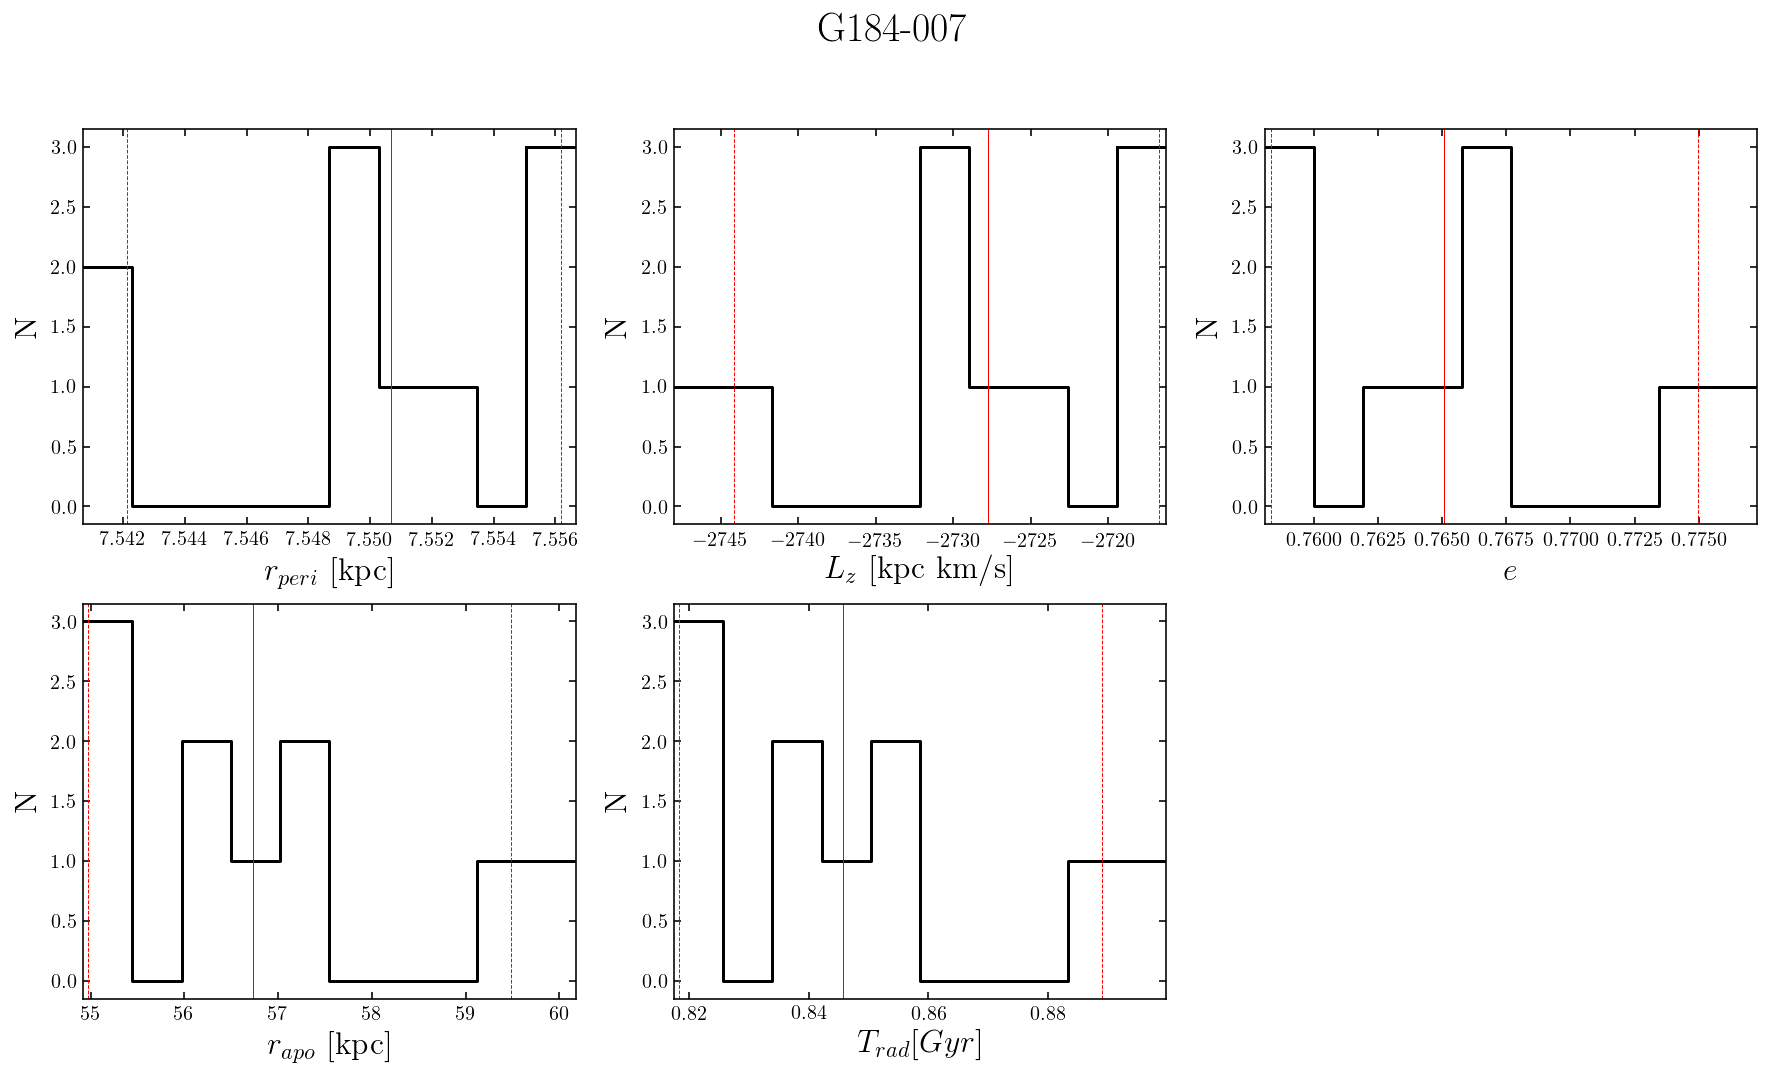

G184-007
rp [kpc]
Median: 7.5507
Central 68th percentile: [7.5421,7.5421]
Errors: [0.0086,0.0055]

rapo [kpc]
Median: 56.7346
Central 68th percentile: [54.9775,54.9775]
Errors: [1.7571,2.7551]

Lz [kpc km/s]
Median: -2727.7532
Central 68th percentile: [-2744.1381,-2744.1381]
Errors: [16.3849,11.0508]

Tr [Gyr]
Median: 0.8457
Central 68th percentile: [0.8184,0.8184]
Errors: [0.0273,0.0432]

eccen.
Median: 0.7651
Central 68th percentile: [0.7583,0.7583]
Errors: [0.0068,0.0099]



A Jupyter Widget

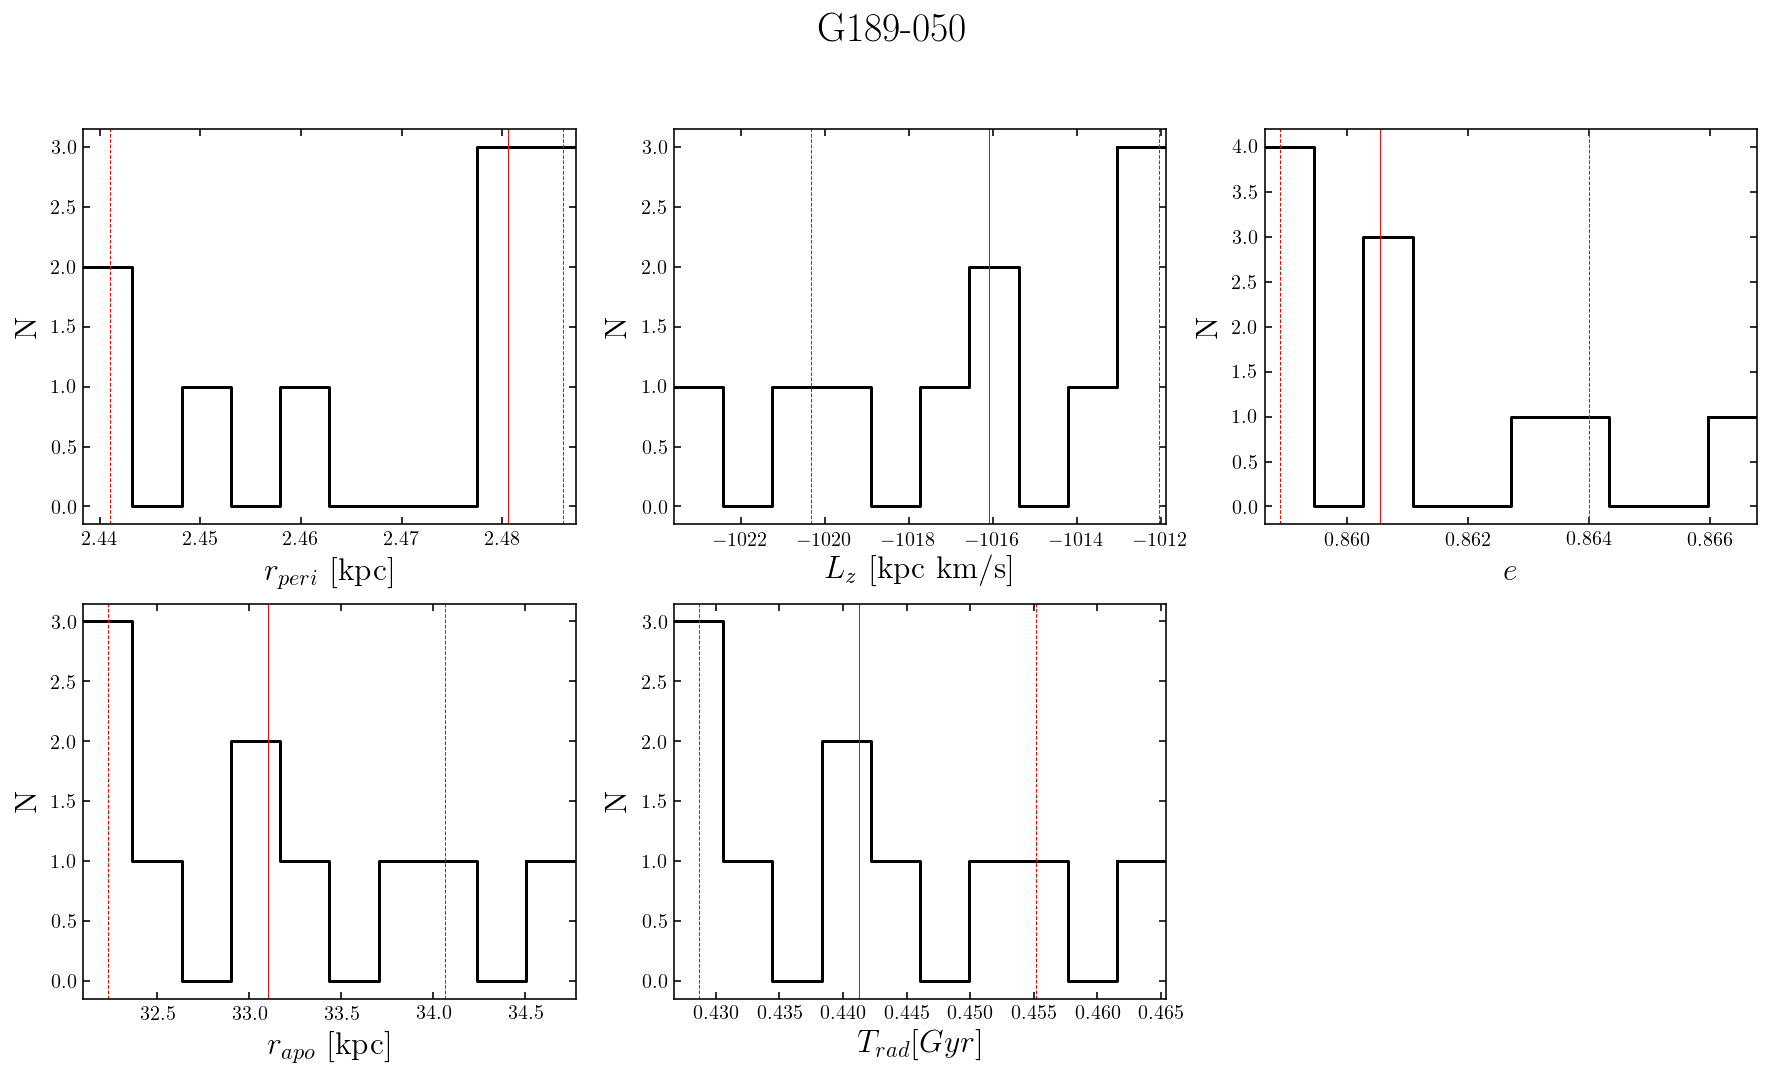

G189-050
rp [kpc]
Median: 2.4806
Central 68th percentile: [2.441,2.441]
Errors: [0.0396,0.0055]

rapo [kpc]
Median: 33.1017
Central 68th percentile: [32.2317,32.2317]
Errors: [0.87,0.9634]

Lz [kpc km/s]
Median: -1016.0806
Central 68th percentile: [-1020.3241,-1020.3241]
Errors: [4.2434,4.0372]

Tr [Gyr]
Median: 0.4413
Central 68th percentile: [0.4287,0.4287]
Errors: [0.0126,0.0139]

eccen.
Median: 0.8606
Central 68th percentile: [0.8589,0.8589]
Errors: [0.0017,0.0034]



A Jupyter Widget

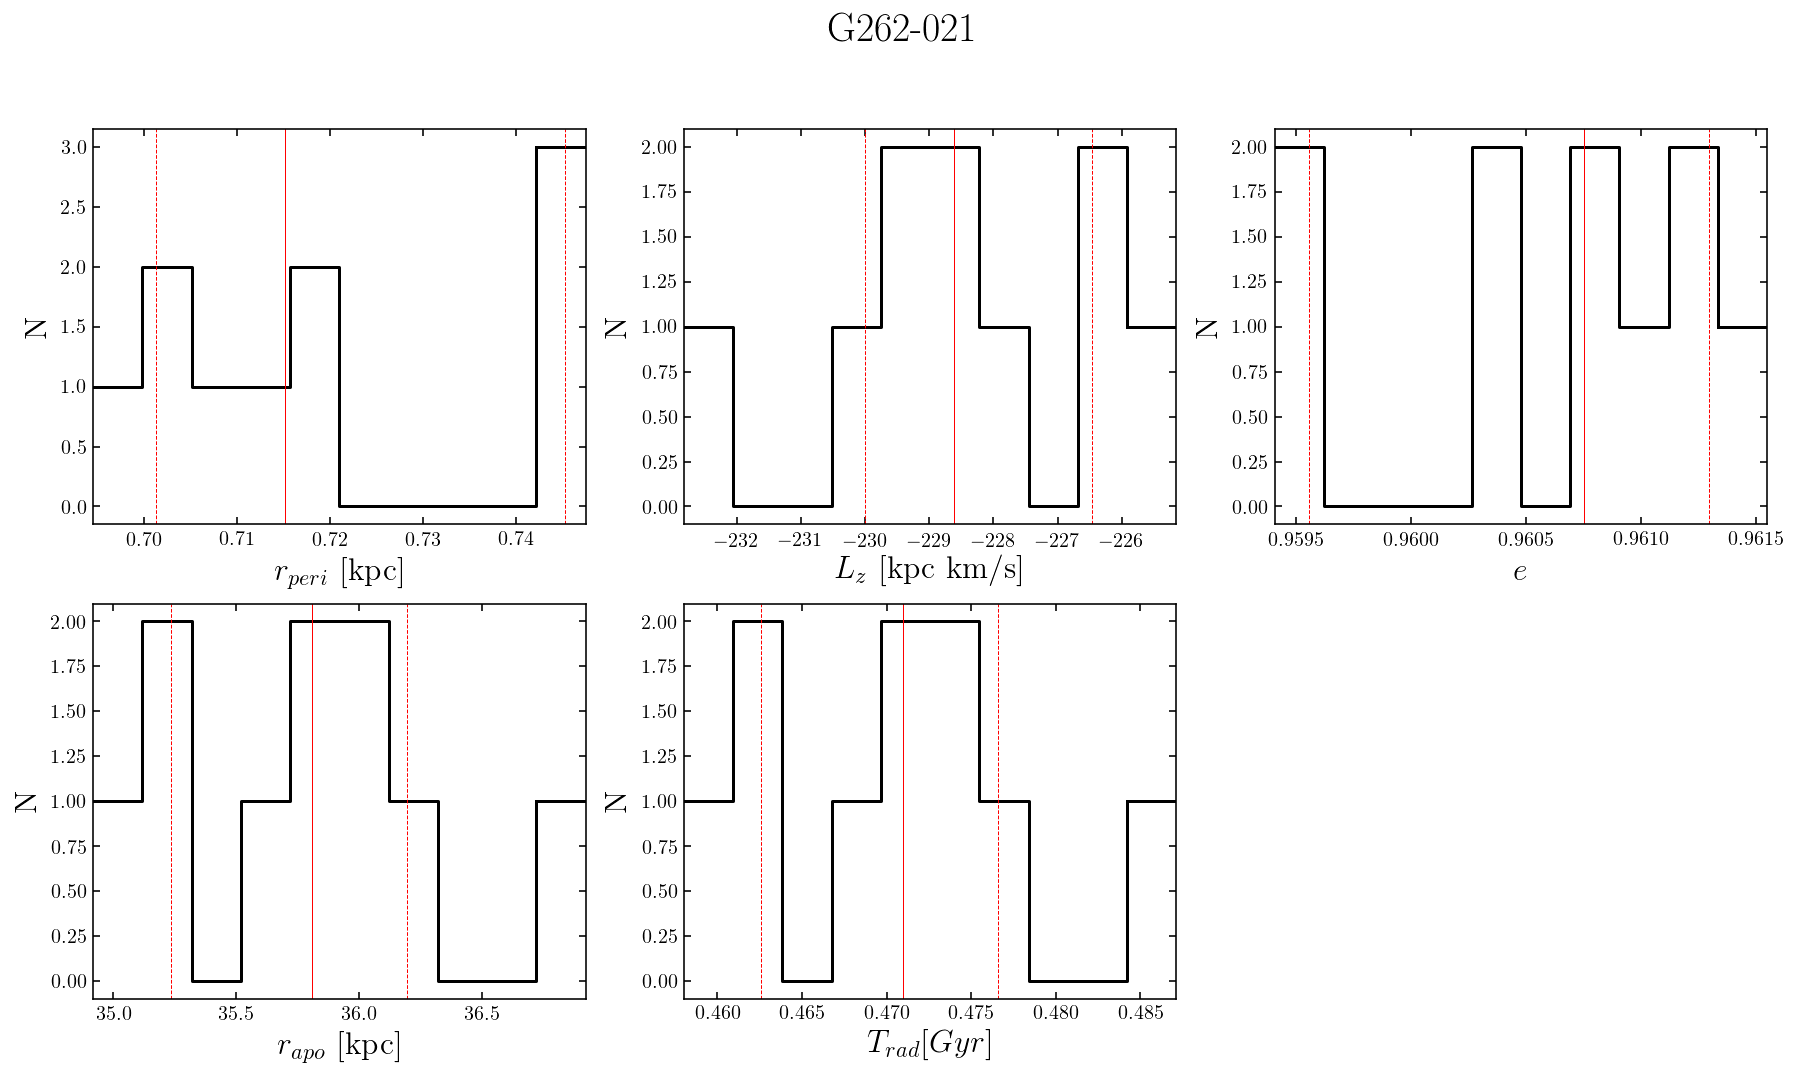

G262-021
rp [kpc]
Median: 0.7152
Central 68th percentile: [0.7013,0.7013]
Errors: [0.0139,0.0301]

rapo [kpc]
Median: 35.8102
Central 68th percentile: [35.234,35.234]
Errors: [0.5762,0.3867]

Lz [kpc km/s]
Median: -228.62
Central 68th percentile: [-230.0042,-230.0042]
Errors: [1.3842,2.1579]

Tr [Gyr]
Median: 0.4709
Central 68th percentile: [0.4626,0.4626]
Errors: [0.0083,0.0056]

eccen.
Median: 0.9608
Central 68th percentile: [0.9596,0.9596]
Errors: [0.0012,0.0005]



In [8]:
# Evaluate
mw2014_stats = evaluate_orbit_parameters(potential.MWPotential2014, 'MWPotential2014', 
                          10, star_names, tab, vrad, vrad_err, 
                          include_stars)
make_latex_table( mw2014_stats, star_names, filename='MWPotential2014.txt' )


## A Second Potential
Loop over each star and determine orbital parameters

A Jupyter Widget

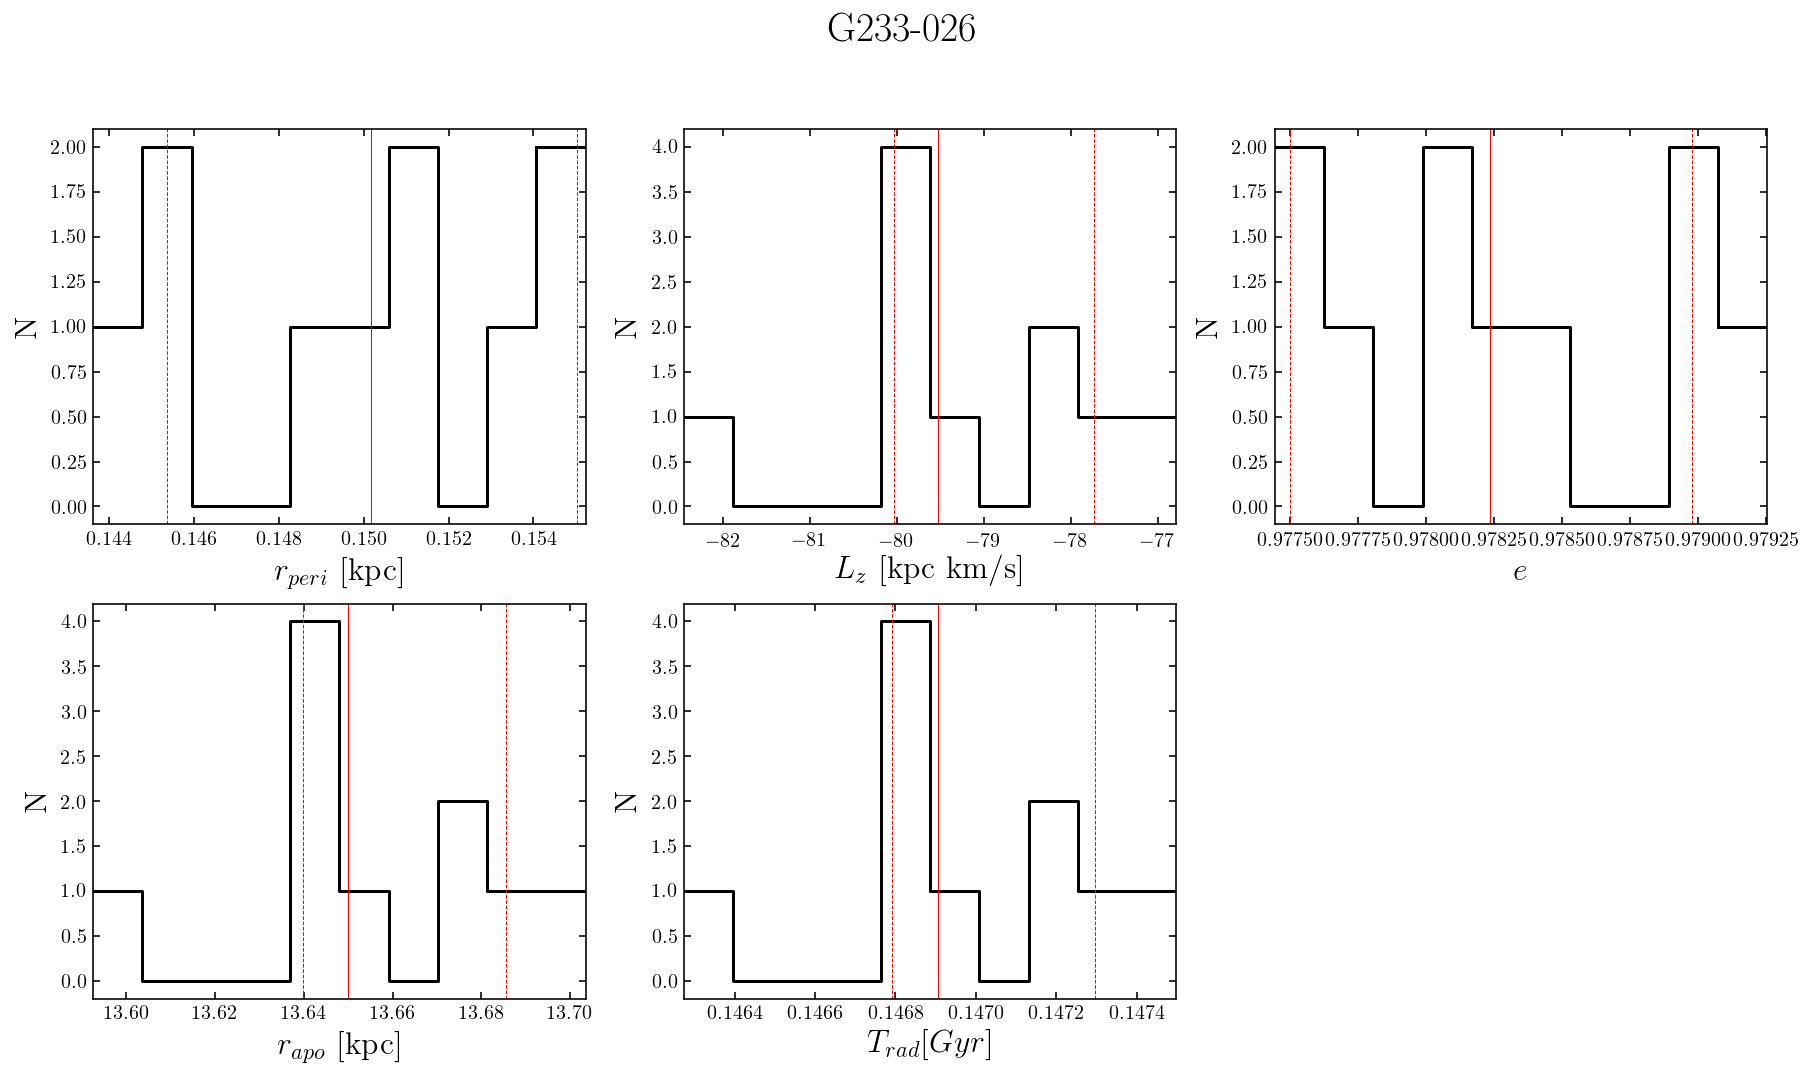

G233-026
rp [kpc]
Median: 0.1502
Central 68th percentile: [0.1454,0.1454]
Errors: [0.0048,0.0049]

rapo [kpc]
Median: 13.65
Central 68th percentile: [13.6398,13.6398]
Errors: [0.0102,0.0355]

Lz [kpc km/s]
Median: -79.5297
Central 68th percentile: [-80.0367,-80.0367]
Errors: [0.507,1.7986]

Tr [Gyr]
Median: 0.1469
Central 68th percentile: [0.1468,0.1468]
Errors: [0.0001,0.0004]

eccen.
Median: 0.9782
Central 68th percentile: [0.9775,0.9775]
Errors: [0.0007,0.0007]



A Jupyter Widget

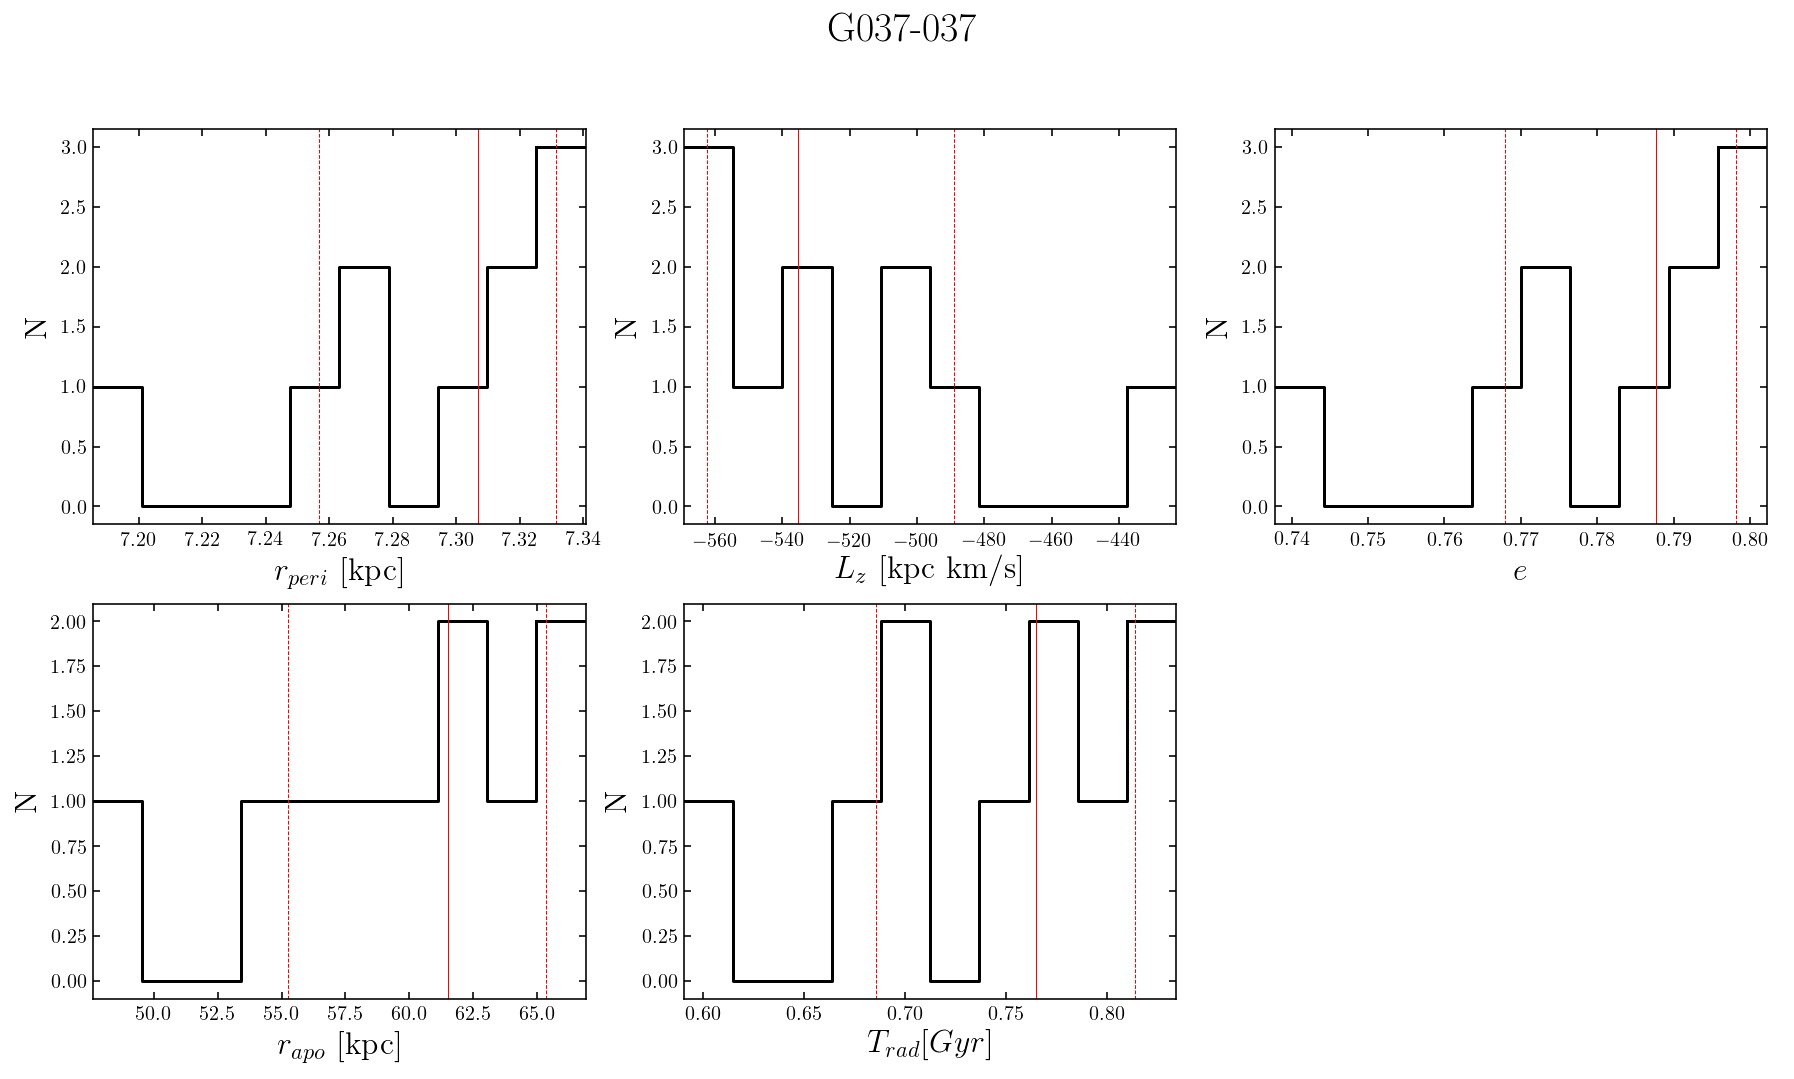

G037-037
rp [kpc]
Median: 7.3067
Central 68th percentile: [7.2568,7.2568]
Errors: [0.0499,0.0246]

rapo [kpc]
Median: 61.522
Central 68th percentile: [55.2679,55.2679]
Errors: [6.2541,3.8176]

Lz [kpc km/s]
Median: -535.5144
Central 68th percentile: [-562.4842,-562.4842]
Errors: [26.9698,46.5977]

Tr [Gyr]
Median: 0.765
Central 68th percentile: [0.6856,0.6856]
Errors: [0.0793,0.0492]

eccen.
Median: 0.7877
Central 68th percentile: [0.7679,0.7679]
Errors: [0.0198,0.0106]



A Jupyter Widget

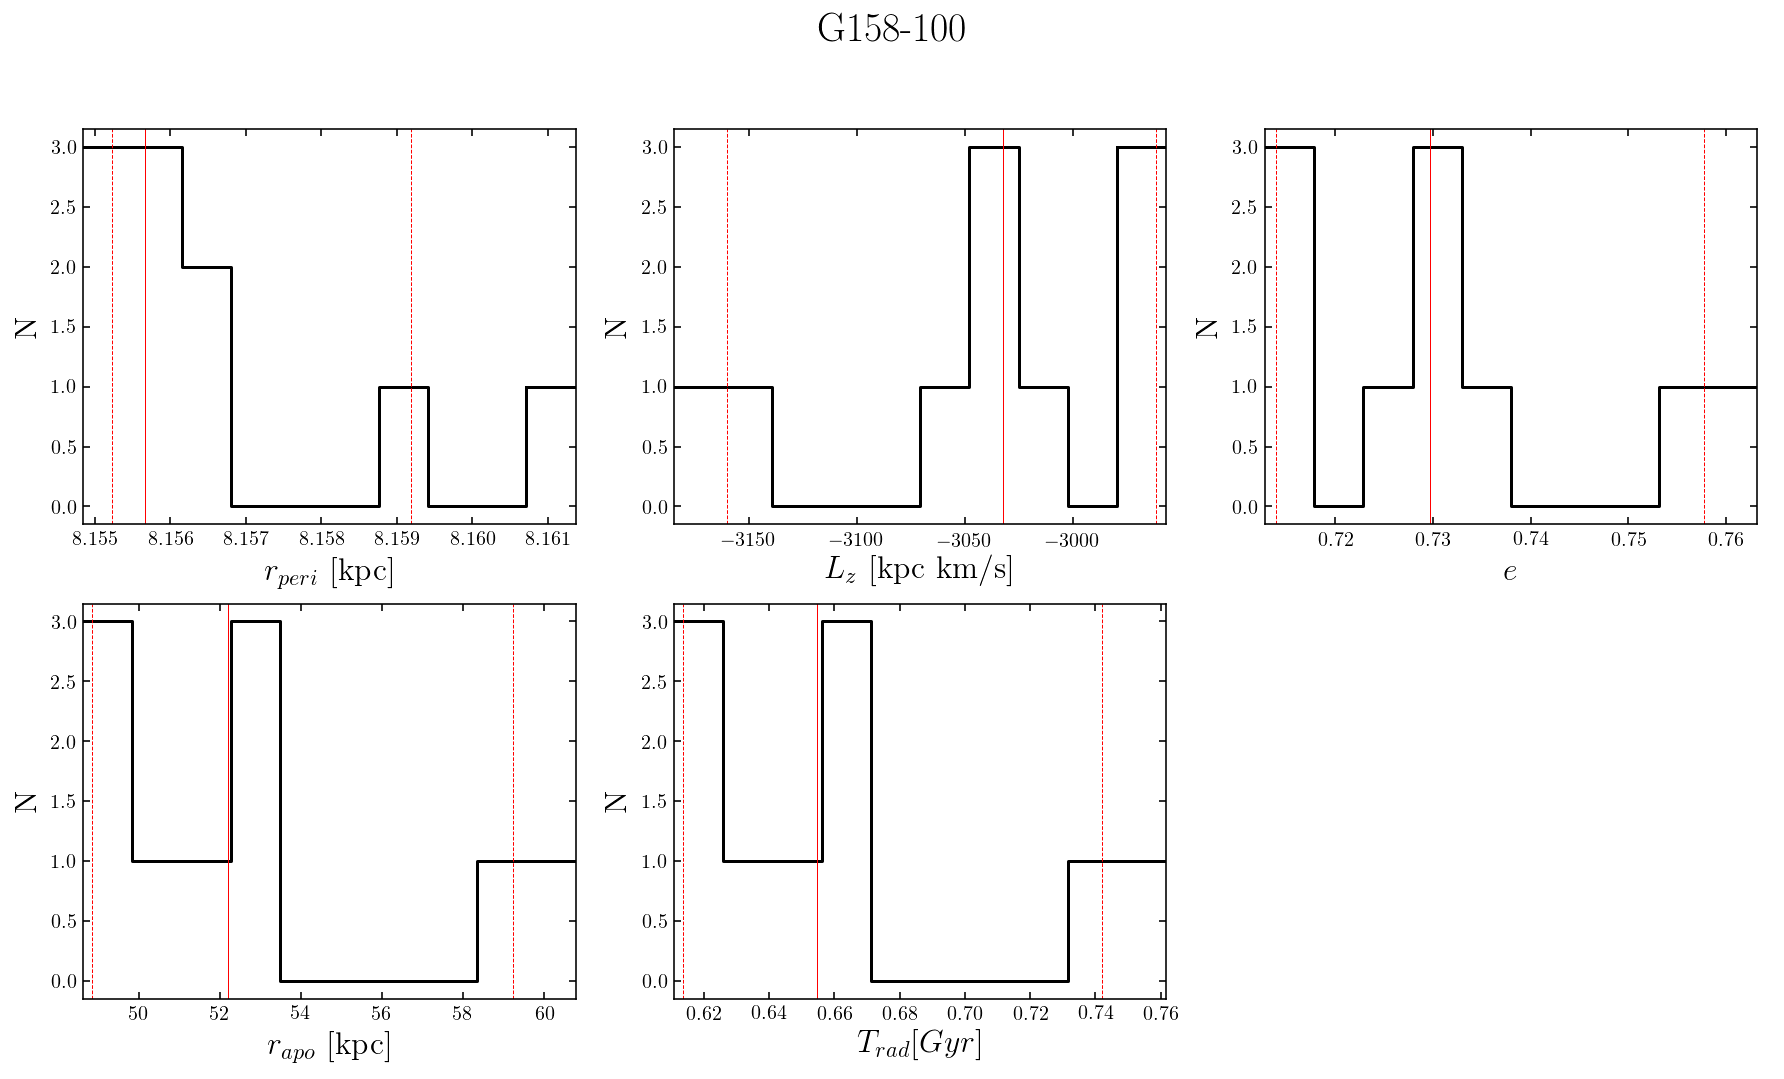

G158-100
rp [kpc]
Median: 8.1557
Central 68th percentile: [8.1552,8.1552]
Errors: [0.0004,0.0035]

rapo [kpc]
Median: 52.1999
Central 68th percentile: [48.851,48.851]
Errors: [3.3488,7.0135]

Lz [kpc km/s]
Median: -3032.222
Central 68th percentile: [-3160.2024,-3160.2024]
Errors: [127.9803,70.7852]

Tr [Gyr]
Median: 0.6546
Central 68th percentile: [0.6135,0.6135]
Errors: [0.041,0.0875]

eccen.
Median: 0.7297
Central 68th percentile: [0.7139,0.7139]
Errors: [0.0159,0.0281]



A Jupyter Widget

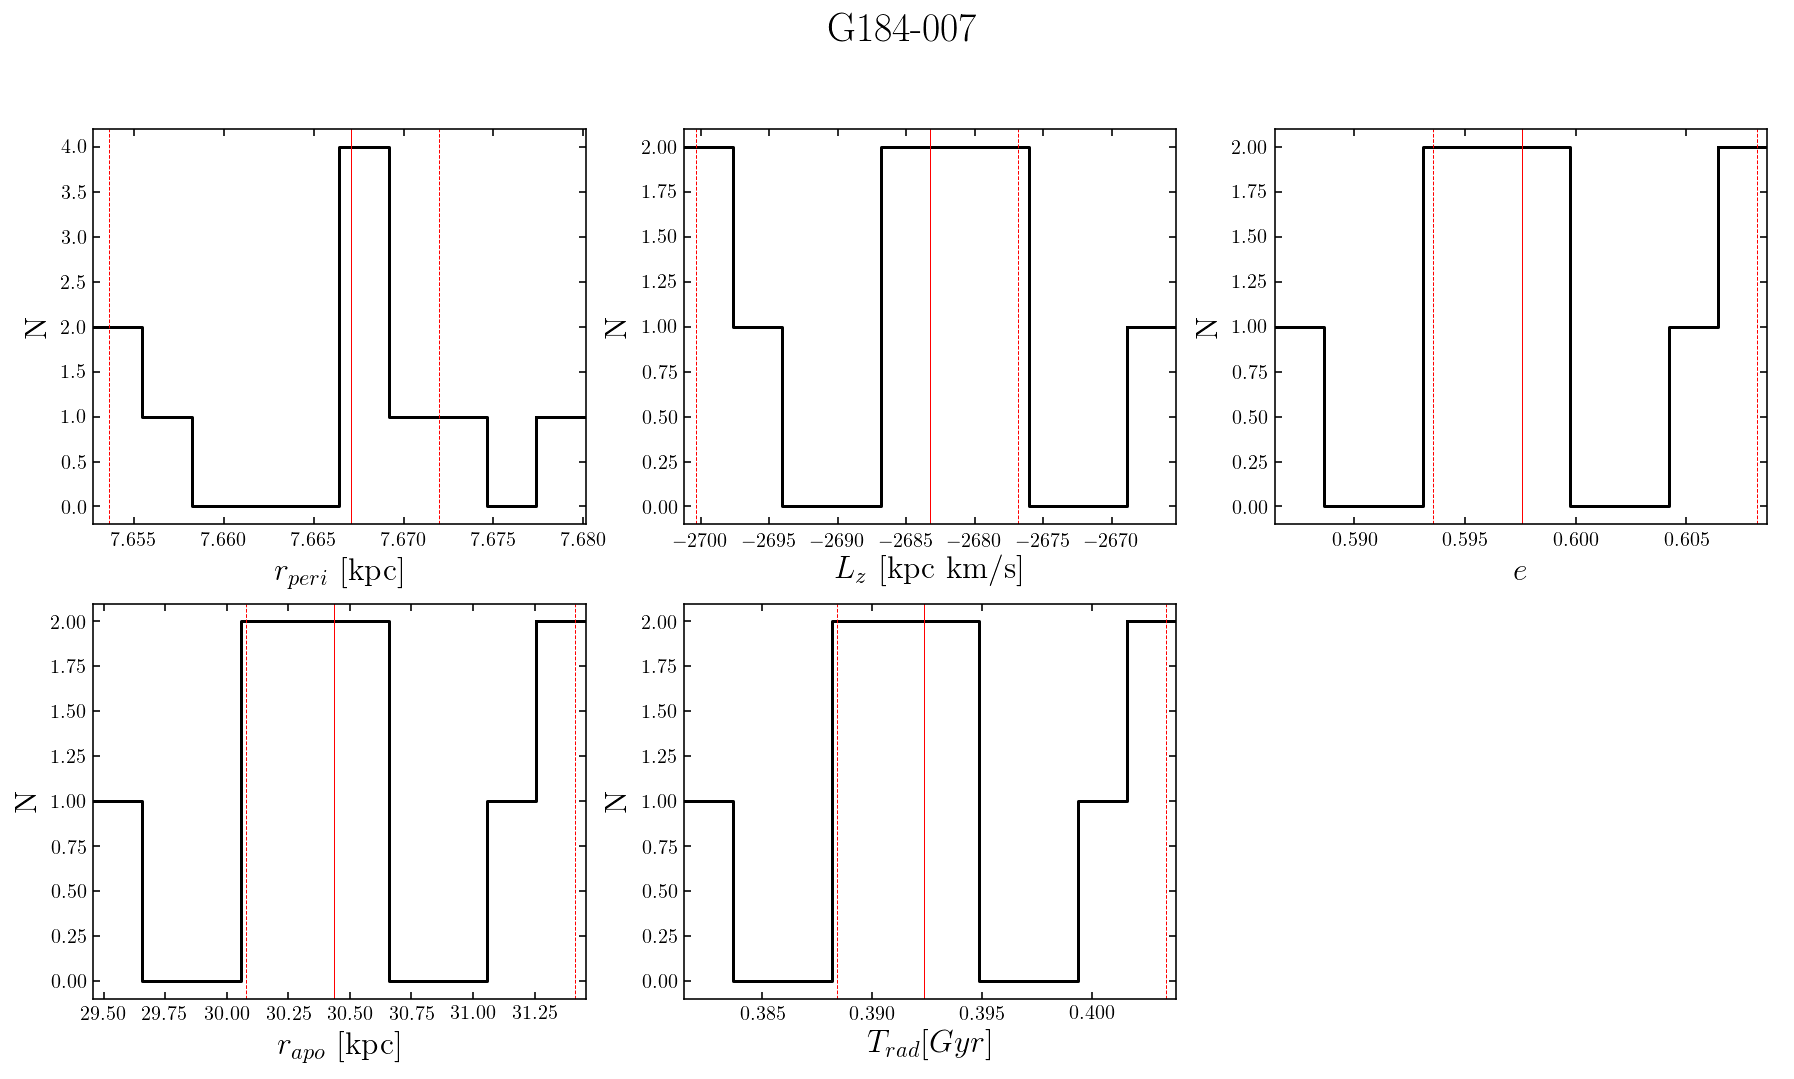

G184-007
rp [kpc]
Median: 7.6671
Central 68th percentile: [7.6536,7.6536]
Errors: [0.0134,0.0049]

rapo [kpc]
Median: 30.4361
Central 68th percentile: [30.0793,30.0793]
Errors: [0.3568,0.9786]

Lz [kpc km/s]
Median: -2683.2409
Central 68th percentile: [-2700.3663,-2700.3663]
Errors: [17.1254,6.4177]

Tr [Gyr]
Median: 0.3924
Central 68th percentile: [0.3884,0.3884]
Errors: [0.004,0.011]

eccen.
Median: 0.5976
Central 68th percentile: [0.5936,0.5936]
Errors: [0.004,0.0106]



A Jupyter Widget

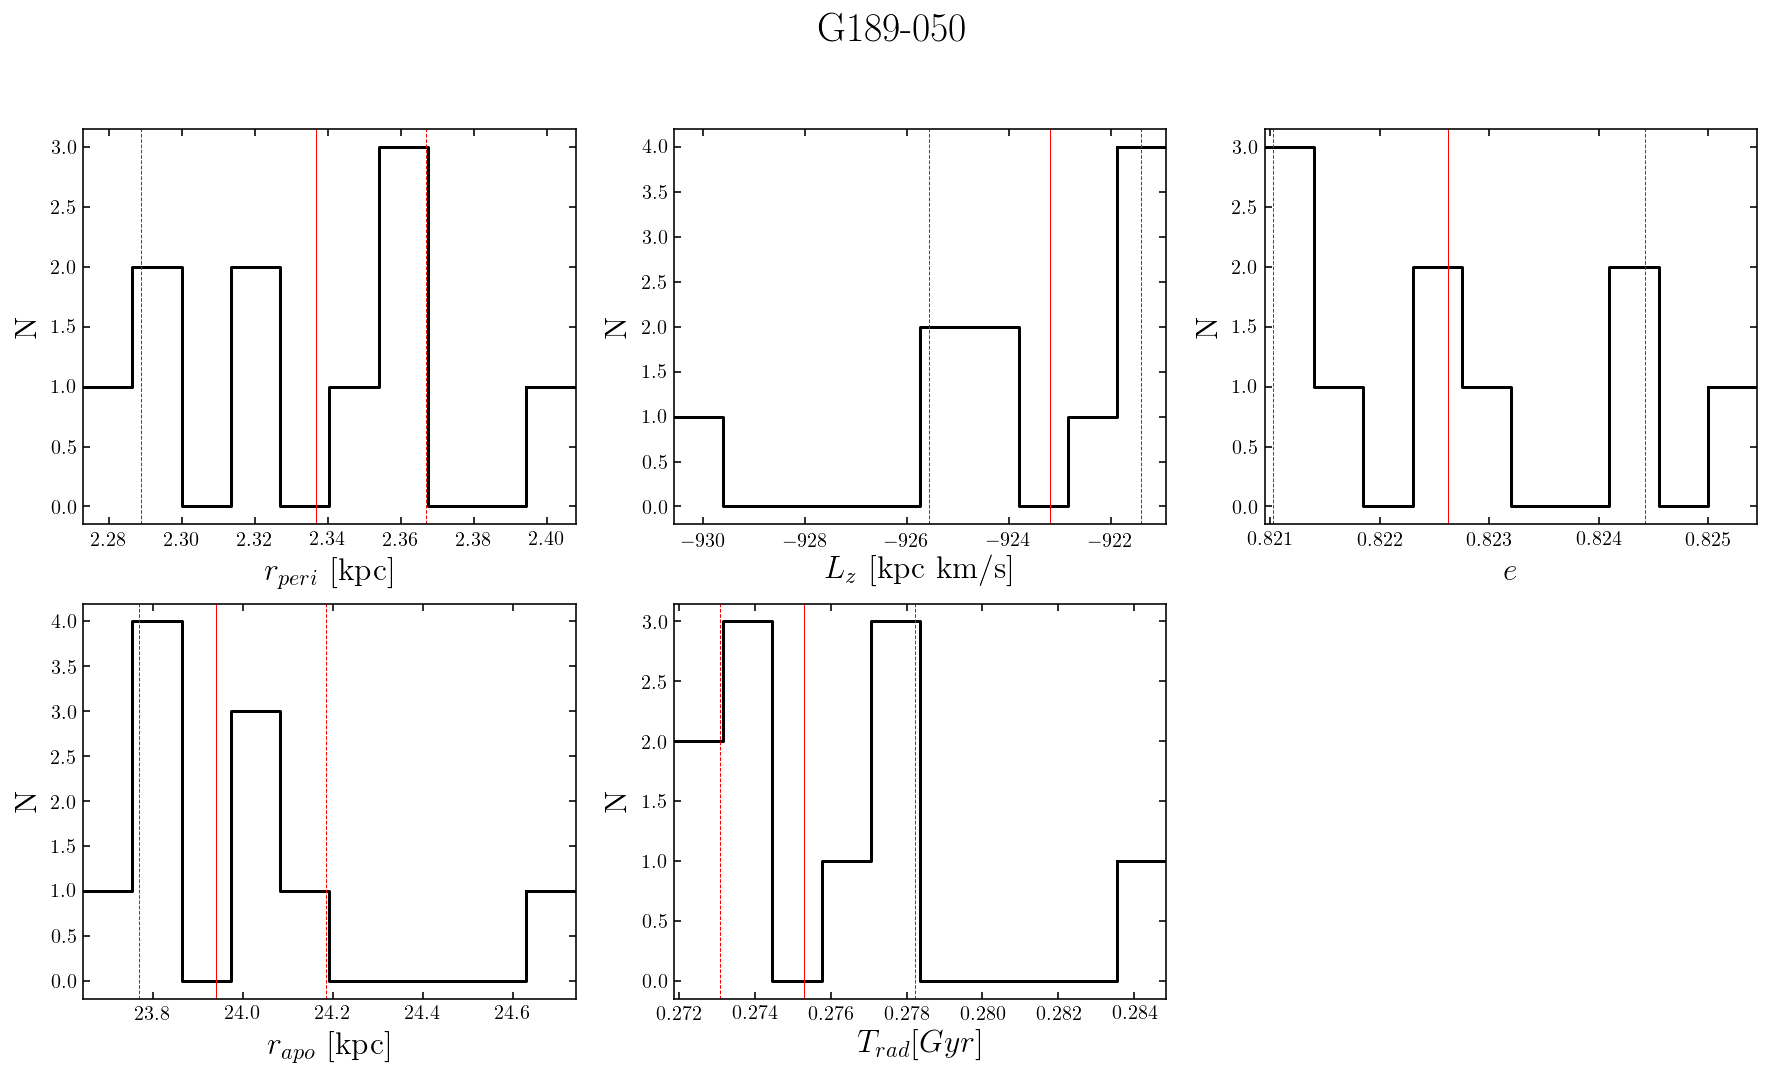

G189-050
rp [kpc]
Median: 2.3367
Central 68th percentile: [2.2888,2.2888]
Errors: [0.0479,0.0302]

rapo [kpc]
Median: 23.9411
Central 68th percentile: [23.7695,23.7695]
Errors: [0.1716,0.2434]

Lz [kpc km/s]
Median: -923.2033
Central 68th percentile: [-925.5617,-925.5617]
Errors: [2.3584,1.7886]

Tr [Gyr]
Median: 0.2753
Central 68th percentile: [0.2731,0.2731]
Errors: [0.0022,0.0029]

eccen.
Median: 0.8226
Central 68th percentile: [0.821,0.821]
Errors: [0.0016,0.0018]



A Jupyter Widget

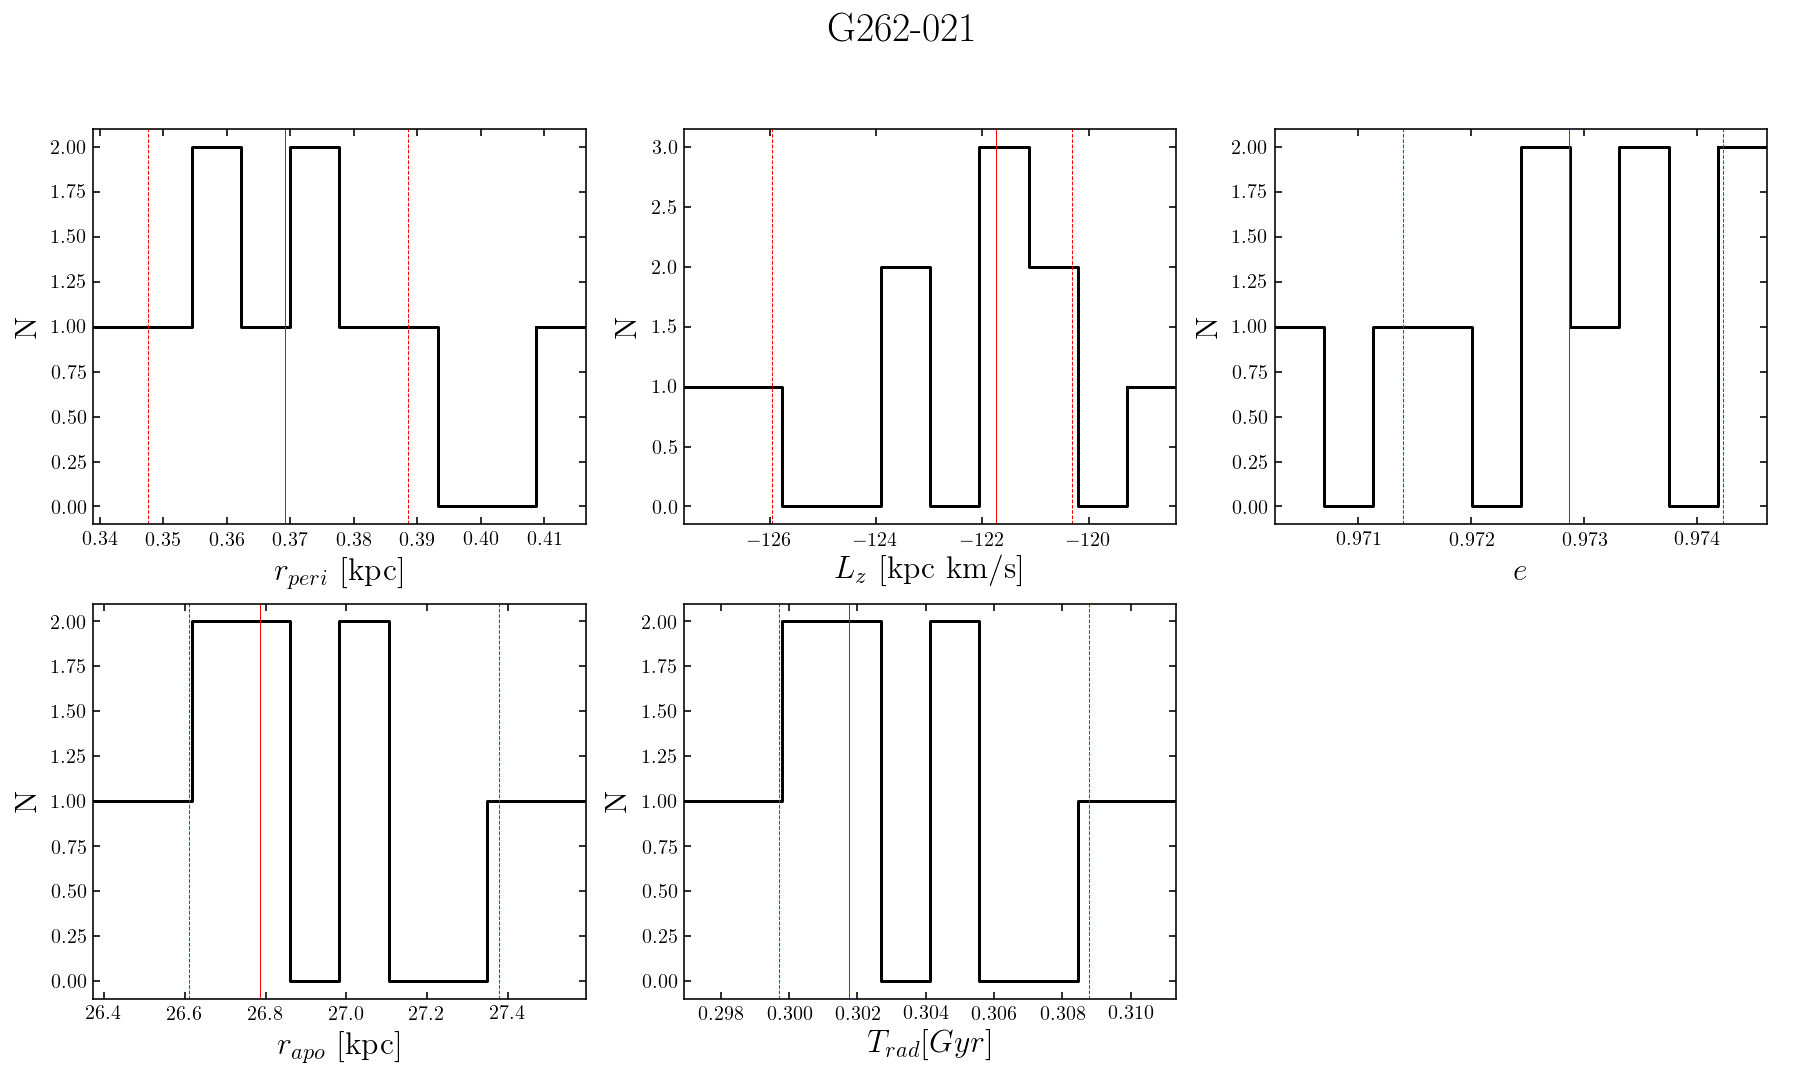

G262-021
rp [kpc]
Median: 0.3692
Central 68th percentile: [0.3477,0.3477]
Errors: [0.0216,0.0193]

rapo [kpc]
Median: 26.7872
Central 68th percentile: [26.6103,26.6103]
Errors: [0.1769,0.5902]

Lz [kpc km/s]
Median: -121.7454
Central 68th percentile: [-125.9504,-125.9504]
Errors: [4.205,1.4408]

Tr [Gyr]
Median: 0.3018
Central 68th percentile: [0.2997,0.2997]
Errors: [0.0021,0.007]

eccen.
Median: 0.9729
Central 68th percentile: [0.9714,0.9714]
Errors: [0.0015,0.0014]



In [9]:
# Evaluate
m17_stats = evaluate_orbit_parameters(ohstars.potential.McMillan2017, 'McMillan2017', 
                          10, star_names, tab, vrad, vrad_err, 
                          include_stars)
make_latex_table( m17_stats, star_names, filename='Mcmillan2017.txt' )